## Phase 1 : Detect Frame change and adjust for frame shift



In [ ]:
# Import and download required library

!pip install tiffile
!pip install image_registration

import cv2
from matplotlib import pyplot as plt
import tiffile as tif
import numpy as np
from google.colab.patches import cv2_imshow
from scipy.ndimage import uniform_filter1d
from skimage import io
from image_registration import cross_correlation_shifts
from scipy.ndimage import shift
from scipy.optimize import minimize, differential_evolution
from scipy.signal import correlate2d
from scipy.signal import fftconvolve

from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 2.7 MB/s eta 0:00:00
Mounted at /content/drive



#### 1.1 Frame Change Identification

This section will identify top 10 shifts along with the most significant shifts. It then find the most representitive frame in between these significant changes.

In [ ]:
# Calculate the average value within a window
def calculate_window_average(video, start, end):
    return np.mean(video[start:end], axis=0)

# Find the representative frame: find the frame that is closest to the average frame in a certain frame sequence
def find_representative_frame(video, start_frame, end_frame):
    avg_frame = calculate_window_average(video, start_frame, end_frame)

    min_diff = float('inf')
    representative_frame = start_frame

    # Find the frame closest to the average between start_frame and end_frame
    for i in range(start_frame, end_frame):
        current_frame = video[i]
        diff = np.sum(np.abs(current_frame - avg_frame))
        if diff < min_diff:
            min_diff = diff
            representative_frame = i

    return representative_frame

# Find and print the Top 10 shifts, plot the frame difference curve
def process_video_find_shifts(file_path):
    print(f"Processing: {file_path}")

    # Load the video
    video = tif.imread(file_path)
    total_frames = video.shape[0]
    window_size = 1
    frame_differences = []

    # Calculate frame differences
    for i in range(window_size, total_frames - window_size):
        prev_avg = calculate_window_average(video, i - window_size, i)
        next_avg = calculate_window_average(video, i, i + window_size)
        frame_diff = np.sum(cv2.absdiff(prev_avg, next_avg))
        frame_differences.append((i, frame_diff))

    frame_differences = np.array(frame_differences, dtype=[('frame', int), ('diff', float)])

    # Plot the frame differences over time
    plt.figure(figsize=(10, 6))
    plt.plot(frame_differences['frame'], frame_differences['diff'], label='Frame Differences', color='blue')

    # Get the top 10 frames with the largest differences, sorted by frame index in ascending order
    sorted_differences = np.sort(frame_differences, order='diff')[::-1]
    top_10_frames = sorted_differences[:10]
    # Output the frames where the most significant shifts occurred
    print("Top 10 shifts detected at frames:", top_10_frames)

    # Print the index of the most significant shift
    most_significant_frame = top_10_frames[0]['frame']
    print('Most significant shift occurs at frame:', most_significant_frame)

    # Optionally, you can print the frame number and corresponding difference value
    for frame_info in top_10_frames:
        print(f"Frame {frame_info['frame']} has a difference sum of {frame_info['diff']}")

    # Optionally mark the top 10 points in the plot
    plt.scatter([frame_info['frame'] for frame_info in top_10_frames],
                [frame_info['diff'] for frame_info in top_10_frames],
                color='red', label='Top 10 Shifts', zorder=5)

    # Show the plot with top 10 points marked
    plt.xlabel('Frame Index')
    plt.ylabel('Sum of Pixel Differences')
    plt.title('Frame Differences Over Time')
    plt.legend()
    plt.show()

    top_10_frame_indices = sorted([frame_info['frame'] for frame_info in top_10_frames])

    return most_significant_frame, top_10_frame_indices, video



# Find the representative frame between shifts
def process_video_find_representative(top_10_frame_indices, video):
    total_frames = video.shape[0]
    representative_frames = []

    # Handle the first interval (from 0 to the first shift)
    first_frame = 0
    first_shift = top_10_frame_indices[0]
    representative_frame = find_representative_frame(video, first_frame, first_shift)
    representative_frames.append((representative_frame, first_frame, first_shift))
    print(f"Representative frame between {first_frame} and {first_shift} is {representative_frame}")

    # Handle the representative frames between adjacent shifts
    for j in range(len(top_10_frame_indices) - 1):
        start_frame = top_10_frame_indices[j]
        end_frame = top_10_frame_indices[j + 1]
        representative_frame = find_representative_frame(video, start_frame, end_frame)
        representative_frames.append((representative_frame, start_frame, end_frame))
        print(f"Representative frame between {start_frame} and {end_frame} is {representative_frame}")

    # Handle the last interval (from the last shift to the last frame)
    last_shift = top_10_frame_indices[-1]
    last_frame = total_frames - 1
    representative_frame = find_representative_frame(video, last_shift, last_frame)
    representative_frames.append((representative_frame, last_shift, last_frame))
    print(f"Representative frame between {last_shift} and {last_frame} is {representative_frame}")

    return representative_frames

# Plot the representative frames
def plot_representative_frames(representative_frames, video):
    fig, axs = plt.subplots(len(representative_frames), figsize=(10, 15))
    fig.suptitle('Representative Frames')

    for idx, (rep_frame, start_frame, end_frame) in enumerate(representative_frames):
        frame = video[rep_frame]
        axs[idx].imshow(frame, cmap='gray')
        axs[idx].set_title(f"Representative Frame: {rep_frame} (Between {start_frame} and {end_frame})")
        axs[idx].axis('off')

    plt.tight_layout()
    plt.show()



Processing: /content/drive/My Drive/capstone/mouse5/m5_frames_28000_29000.tiff
Top 10 shifts detected at frames: [(970, 2.91407876e+08) (630, 2.19019362e+08) (576, 1.89963323e+08)
 (631, 1.85613867e+08) (627, 1.46688011e+08) (680, 1.27462253e+08)
 (658, 1.18064688e+08) (969, 1.13052124e+08) (968, 9.97091340e+07)
 (120, 9.23537230e+07)]
Most significant shift occurs at frame: 970
Frame 970 has a difference sum of 291407876.0
Frame 630 has a difference sum of 219019362.0
Frame 576 has a difference sum of 189963323.0
Frame 631 has a difference sum of 185613867.0
Frame 627 has a difference sum of 146688011.0
Frame 680 has a difference sum of 127462253.0
Frame 658 has a difference sum of 118064688.0
Frame 969 has a difference sum of 113052124.0
Frame 968 has a difference sum of 99709134.0
Frame 120 has a difference sum of 92353723.0


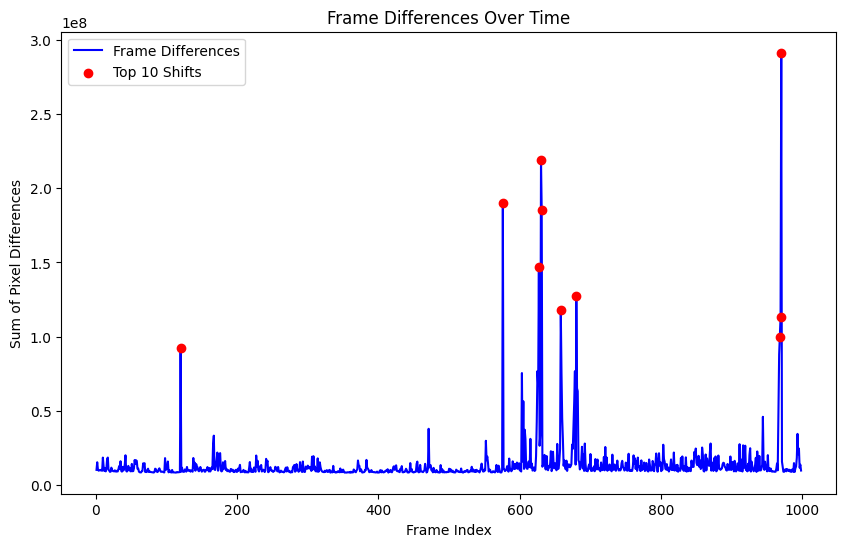

In [ ]:
# Use your TIFF file path to run the code
file_path = '/content/drive/My Drive/capstone/mouse5/m5_frames_28000_29000.tiff'
most_significant_frame, top_10_frame_indices, video = process_video_find_shifts(file_path)


In [ ]:
# Find the representative frame between each shift
representative_frames = process_video_find_representative(top_10_frame_indices, video)


Representative frame between 0 and 120 is 57
Representative frame between 120 and 576 is 262
Representative frame between 576 and 627 is 607
Representative frame between 627 and 630 is 628
Representative frame between 630 and 631 is 630
Representative frame between 631 and 658 is 645
Representative frame between 658 and 680 is 678
Representative frame between 680 and 968 is 822
Representative frame between 968 and 969 is 968
Representative frame between 969 and 970 is 969
Representative frame between 970 and 999 is 971


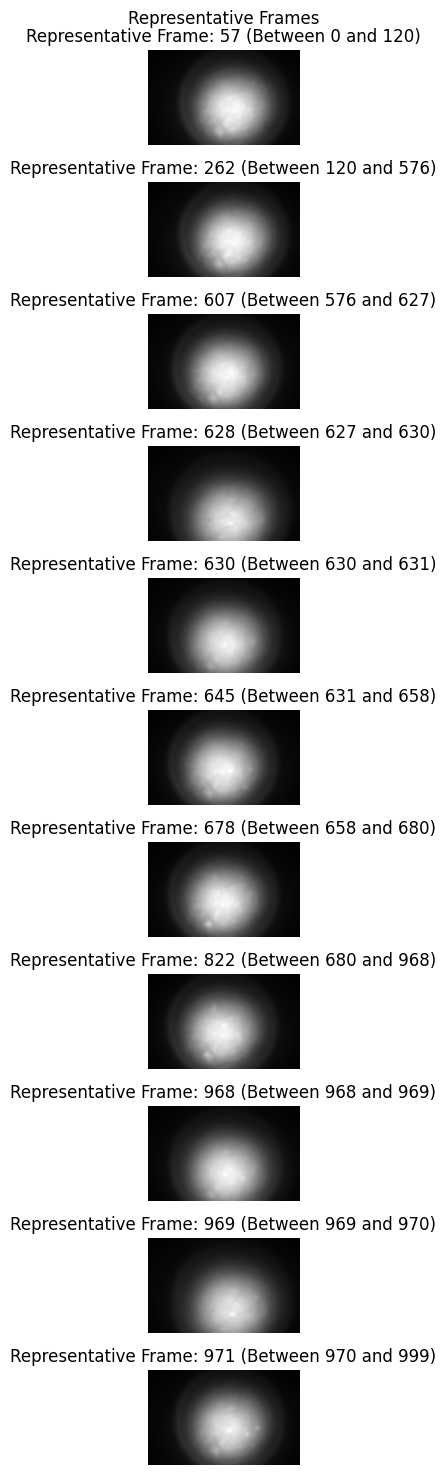

In [ ]:
# Plot all representative frames
plot_representative_frames(representative_frames, video)

#### 1.2 Correct for Frames Shits

In this section, we will first choose a sample frame, which should be the ideal frame in the video. We shift the resest representitive frames to match the sample frame, using mutual information methods. We present both MI models using local optima and global optima

In [ ]:
# Mutual Information
def compute_mutual_information(img1, img2, bins=20):
    # Compute the joint histogram
    hist, _, _ = np.histogram2d(img1.ravel(), img2.ravel(), bins=bins)

    # Convert the joint histogram to joint probability distribution
    pxy = hist / np.sum(hist)
    px = np.sum(pxy, axis=1)  # Marginal distribution for img1
    py = np.sum(pxy, axis=0)  # Marginal distribution for img2

    # Filter out nonnegative value for log
    pxy = pxy[pxy > 0]
    px = px[px > 0]
    py = py[py > 0]

    # Calculate entropies
    Hx = -np.sum(px * np.log(px))
    Hy = -np.sum(py * np.log(py))
    Hxy = -np.sum(pxy * np.log(pxy))

    # Return MI (MI = H(I1) + H(I2) - H(I1,I2))
    MI = Hx + Hy - Hxy
    return MI

# Define the loss function to optimize
def mi_loss(params, img1, img2):
    tx, ty = params  # amount to shift img2 horizontally & vertically

    # Create the transformation matrix for translation
    M = np.float32([[1, 0, tx], [0, 1, ty]])

    # Apply the shift to img2 with same output size as img1
    transformed_img2 = cv2.warpAffine(img2, M, (img1.shape[1], img1.shape[0]), borderMode=cv2.BORDER_REFLECT)

    # Return mi (min -value -> max)
    return -compute_mutual_information(img1, transformed_img2)

def optimize_mi_with_global_search(img1, img2):
    # Define bounds for translation parameters (x_shift, y_shift)
    bounds = [(-50, 50), (-50, 50)]  # Adjust the range based on expected translations

    # Perform global optimization using Differential Evolution
    result = differential_evolution(mi_loss, bounds, args=(img1, img2), strategy='best1bin', maxiter=100)

    # Return optimized translation
    return result.x

# Adjusted align_frames_global function
def align_frames_global(video, input_frame_index, offset_frame_indices):
    results = []  # Initialize an empty list to store the results

    for rep_frame_info in offset_frame_indices:
        representative_frame, start_frame, end_frame = rep_frame_info

        # Print the representative frame and the interval
        print(f"Representative frame for range {start_frame}-{end_frame} is {representative_frame}")

        # Select the input frame and the offset frame
        input_frame = np.uint8(video[input_frame_index])
        offset_frame = np.uint8(video[representative_frame])

        # Set the initial (x_shift, y_shift)
        initial_guess = [30, 40]

       # Local optimization: Use Powell optimization
        local_translation = minimize(mi_loss, initial_guess, args=(input_frame, offset_frame), method='Powell').x
        print(f"Local Optimized translation (x, y) for offset frame {representative_frame}: {local_translation}")

        # Global optimization: Use Differential Evolution
        global_translation = optimize_mi_with_global_search(input_frame, offset_frame)
        print(f"Global Optimized translation (x, y) for offset frame {representative_frame}: {global_translation}")

        # Apply the translation parameters from local optimization
        M_local = np.float32([[1, 0, local_translation[0]], [0, 1, local_translation[1]]])
        aligned_offset_frame_local = cv2.warpAffine(offset_frame, M_local, (input_frame.shape[1], input_frame.shape[0]), borderMode=cv2.BORDER_CONSTANT)

        # Apply the translation parameters from global optimization
        M_global = np.float32([[1, 0, global_translation[0]], [0, 1, global_translation[1]]])
        aligned_offset_frame_global = cv2.warpAffine(offset_frame, M_global, (input_frame.shape[1], input_frame.shape[0]), borderMode=cv2.BORDER_CONSTANT)

        # Save the results into a dictionary and append to the results list
        result = {
            'sample_frame_index': input_frame_index,
            'offset_frame_index': representative_frame,
            'frame_range': (start_frame, end_frame),
            'local_MI_shifts': local_translation,
            'global_MI_shifts': global_translation
        }
        results.append(result)

        # Plot the images before and after alignment
        fig, ax = plt.subplots(2, 2, figsize=(10, 10))
        ax[0, 0].imshow(input_frame, cmap='gray')
        ax[0, 0].set_title('Input Frame')

        ax[0, 1].imshow(offset_frame, cmap='gray')
        ax[0, 1].set_title(f'Offset Frame {representative_frame}')

        ax[1, 0].imshow(aligned_offset_frame_local, cmap='gray')
        ax[1, 0].set_title(f'Corrected (MI Local Optimization)')

        ax[1, 1].imshow(aligned_offset_frame_global, cmap='gray')
        ax[1, 1].set_title(f'Corrected (MI Global Optimization)')

        plt.show()

    return results

In [ ]:
# we choose 822 as the sample frame to match
result_example = align_frames_global(video, 822, representative_frames)

In [ ]:
result_example

[{'sample_frame_index': 822,
  'offset_frame_index': 57,
  'frame_range': (0, 120),
  'local_MI_shifts': array([24.49128232, 15.51610059]),
  'global_MI_shifts': array([-49.93133489,  -3.57742336])},
 {'sample_frame_index': 822,
  'offset_frame_index': 262,
  'frame_range': (120, 576),
  'local_MI_shifts': array([-90.01314152, -12.9958258 ]),
  'global_MI_shifts': array([-49.53996261,  -8.08969557])},
 {'sample_frame_index': 822,
  'offset_frame_index': 607,
  'frame_range': (576, 627),
  'local_MI_shifts': array([-14.4905696 ,  -4.03574854]),
  'global_MI_shifts': array([-37.00080973, -14.99780762])},
 {'sample_frame_index': 822,
  'offset_frame_index': 628,
  'frame_range': (627, 630),
  'local_MI_shifts': array([-17.49296927,  25.97495939]),
  'global_MI_shifts': array([-38.94079394, -49.50892678])},
 {'sample_frame_index': 822,
  'offset_frame_index': 630,
  'frame_range': (630, 631),
  'local_MI_shifts': array([-24.96078804, -34.96363379]),
  'global_MI_shifts': array([-31.9442021

#### 1.3 For Other Videos

This section intend to find shifting corrdinates for other videos

In [ ]:
def identify_sample_frame(file_path):
  most_significant_frame, top_10_frame_indices, video = process_video_find_shifts(file_path)
  representative_frames = process_video_find_representative(top_10_frame_indices, video)
  plot_representative_frames(representative_frames, video)

  return most_significant_frame, representative_frames, video

##### mouse 1 17000_18000

Processing: /content/drive/My Drive/capstone/mouse1/m1_frames_17000_18000.tiff
Top 10 shifts detected at frames: [(230, 1.83952346e+08) (126, 1.05406464e+08) (166, 9.41246420e+07)
 (193, 7.46202340e+07) (989, 7.00832940e+07) (192, 5.44654170e+07)
 (840, 5.03367480e+07) (167, 4.75640990e+07) (635, 4.35155330e+07)
 (256, 4.02729070e+07)]
Most significant shift occurs at frame: 230
Frame 230 has a difference sum of 183952346.0
Frame 126 has a difference sum of 105406464.0
Frame 166 has a difference sum of 94124642.0
Frame 193 has a difference sum of 74620234.0
Frame 989 has a difference sum of 70083294.0
Frame 192 has a difference sum of 54465417.0
Frame 840 has a difference sum of 50336748.0
Frame 167 has a difference sum of 47564099.0
Frame 635 has a difference sum of 43515533.0
Frame 256 has a difference sum of 40272907.0


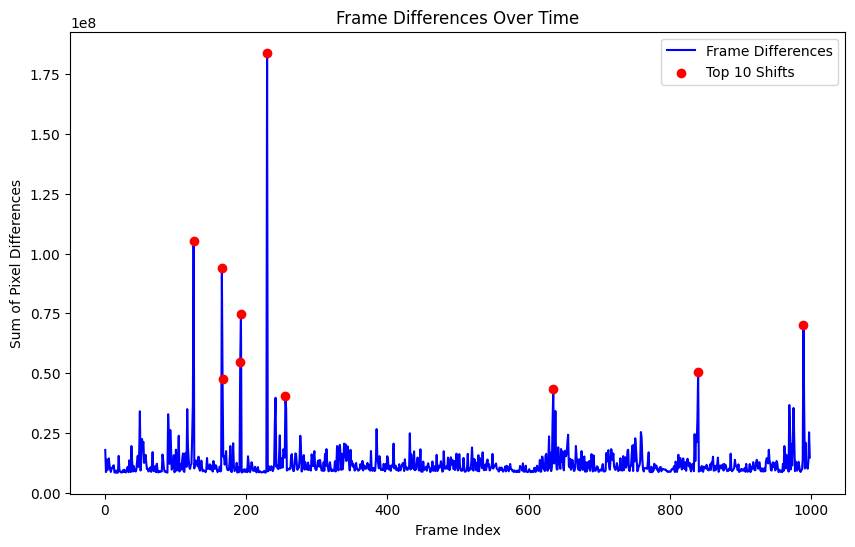

Representative frame between 0 and 126 is 93
Representative frame between 126 and 166 is 139
Representative frame between 166 and 167 is 166
Representative frame between 167 and 192 is 173
Representative frame between 192 and 193 is 192
Representative frame between 193 and 230 is 219
Representative frame between 230 and 256 is 241
Representative frame between 256 and 635 is 561
Representative frame between 635 and 840 is 686
Representative frame between 840 and 989 is 949
Representative frame between 989 and 999 is 993


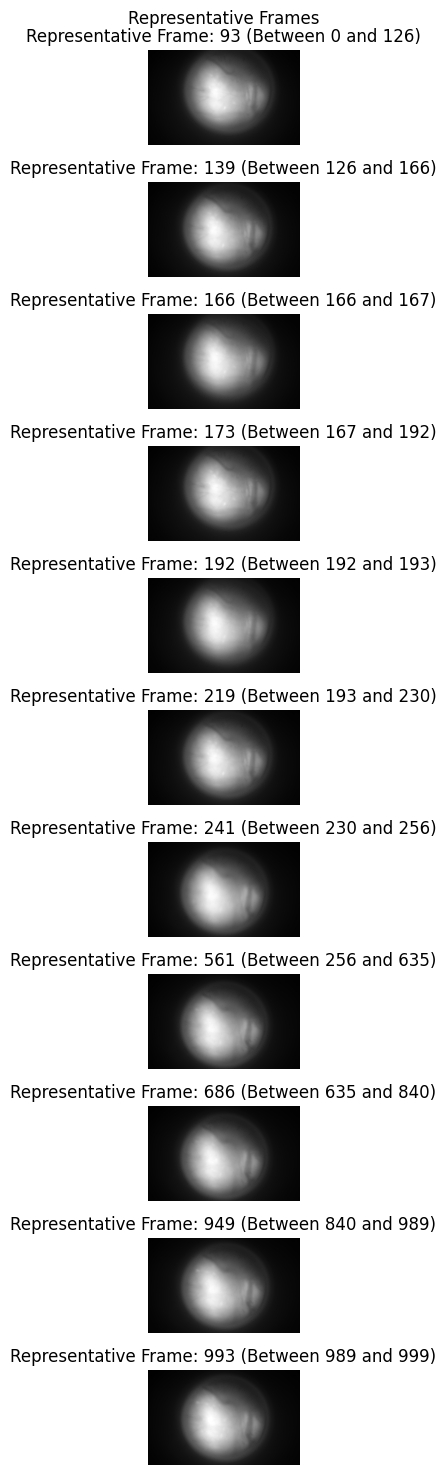

In [ ]:
# mouse 1 17000_18000
most_significant_frame_1, representative_frames_1, video_1 = identify_sample_frame('/content/drive/My Drive/capstone/mouse1/m1_frames_17000_18000.tiff')

In [ ]:
# we choose 241 as the sample frame
result_1 = align_frames_global(video, 241, representative_frames_1)

##### mouse 1 35000_36000

Processing: /content/drive/My Drive/capstone/mouse1/m1_frames_35000_36000.tiff
Top 10 shifts detected at frames: [(666, 1.2848252e+08) (702, 3.1635065e+07) (635, 3.1292562e+07)
 (797, 3.0003300e+07) (748, 2.8614141e+07) (798, 2.8327004e+07)
 (701, 2.8171293e+07) (864, 2.8098930e+07) (794, 2.8043146e+07)
 (868, 2.7787170e+07)]
Most significant shift occurs at frame: 666
Frame 666 has a difference sum of 128482520.0
Frame 702 has a difference sum of 31635065.0
Frame 635 has a difference sum of 31292562.0
Frame 797 has a difference sum of 30003300.0
Frame 748 has a difference sum of 28614141.0
Frame 798 has a difference sum of 28327004.0
Frame 701 has a difference sum of 28171293.0
Frame 864 has a difference sum of 28098930.0
Frame 794 has a difference sum of 28043146.0
Frame 868 has a difference sum of 27787170.0


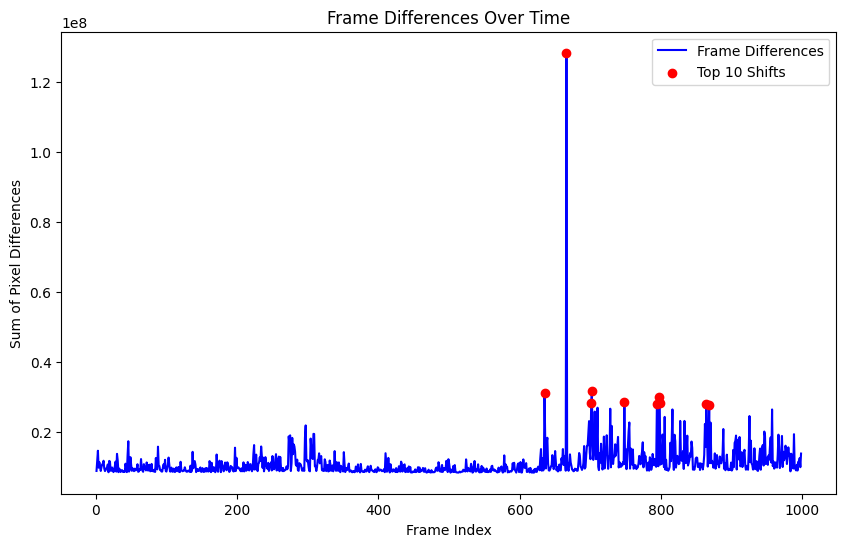

Representative frame between 0 and 635 is 150
Representative frame between 635 and 666 is 652
Representative frame between 666 and 701 is 685
Representative frame between 701 and 702 is 701
Representative frame between 702 and 748 is 715
Representative frame between 748 and 794 is 768
Representative frame between 794 and 797 is 796
Representative frame between 797 and 798 is 797
Representative frame between 798 and 864 is 823
Representative frame between 864 and 868 is 866
Representative frame between 868 and 999 is 918


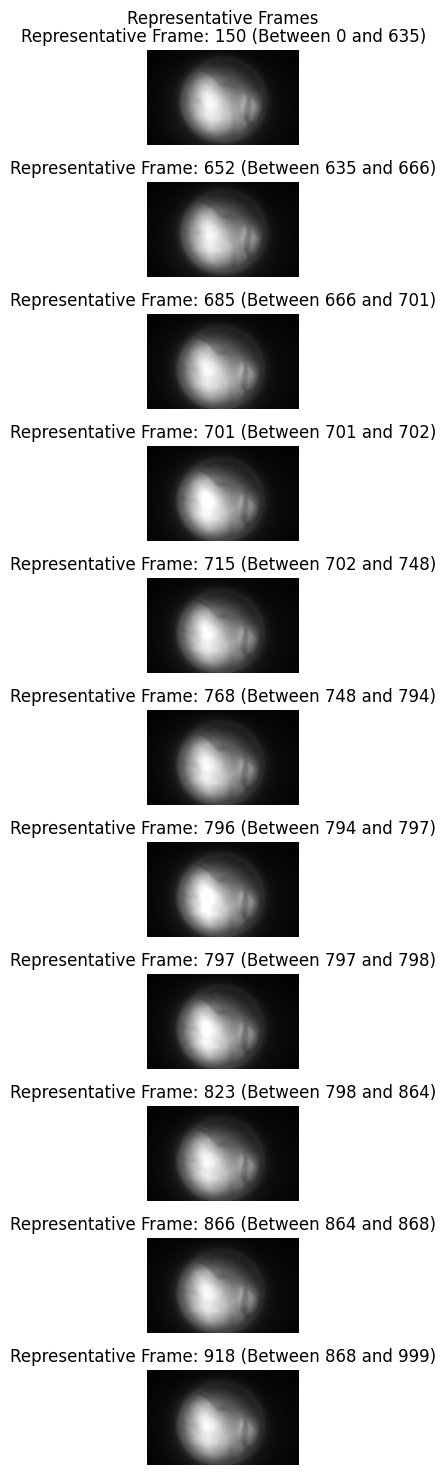

In [ ]:
most_significant_frame_2, representative_frames_2, video_2 = identify_sample_frame('/content/drive/My Drive/capstone/mouse1/m1_frames_35000_36000.tiff')

In [ ]:
# we choose 150 as the sample frame
result_2 = align_frames_global(video, 150, representative_frames_2)

##### mouse 5 16000_17000

Processing: /content/drive/My Drive/capstone/mouse5/m5_frames_16000_17000.tiff
Top 10 shifts detected at frames: [(295, 2.46609627e+08) (819, 3.91627280e+07) (911, 3.13735430e+07)
 (832, 2.97804340e+07) (614, 2.95334070e+07) (718, 2.91667260e+07)
 (347, 2.91200950e+07) (950, 2.81349260e+07) (354, 2.81079860e+07)
 (556, 2.68808170e+07)]
Most significant shift occurs at frame: 295
Frame 295 has a difference sum of 246609627.0
Frame 819 has a difference sum of 39162728.0
Frame 911 has a difference sum of 31373543.0
Frame 832 has a difference sum of 29780434.0
Frame 614 has a difference sum of 29533407.0
Frame 718 has a difference sum of 29166726.0
Frame 347 has a difference sum of 29120095.0
Frame 950 has a difference sum of 28134926.0
Frame 354 has a difference sum of 28107986.0
Frame 556 has a difference sum of 26880817.0


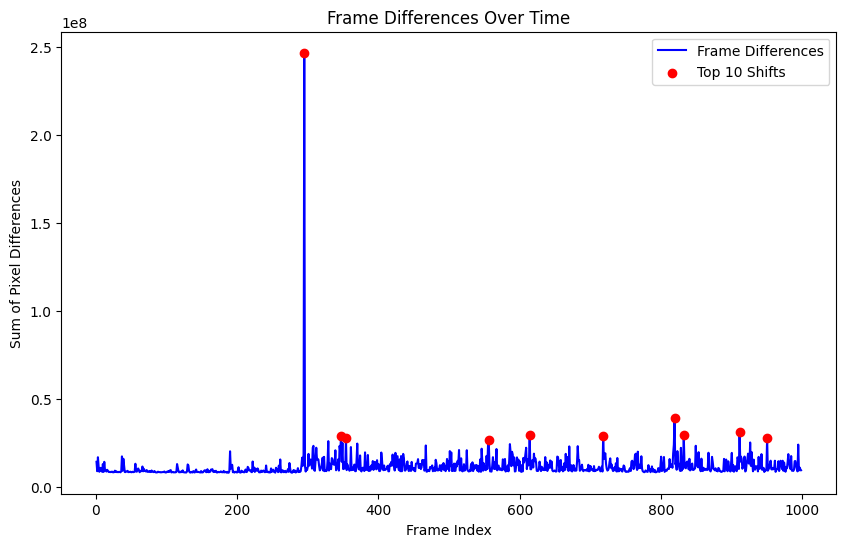

Representative frame between 0 and 295 is 78
Representative frame between 295 and 347 is 344
Representative frame between 347 and 354 is 350
Representative frame between 354 and 556 is 528
Representative frame between 556 and 614 is 609
Representative frame between 614 and 718 is 648
Representative frame between 718 and 819 is 810
Representative frame between 819 and 832 is 825
Representative frame between 832 and 911 is 850
Representative frame between 911 and 950 is 943
Representative frame between 950 and 999 is 971


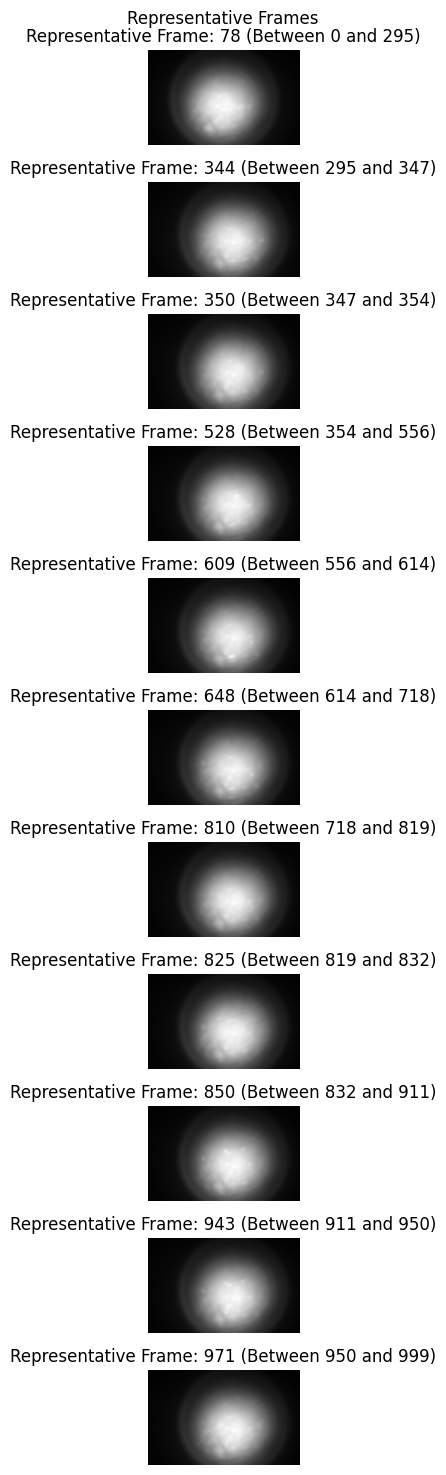

In [ ]:
most_significant_frame_3, representative_frames_3, video_3 = identify_sample_frame('/content/drive/My Drive/capstone/mouse5/m5_frames_16000_17000.tiff')

In [ ]:
# we choose 241 as the sample frame
result_3 = align_frames_global(video, 78, representative_frames_3)